# This notebook computes analytic solutions for the parameter set-up with unequal stratification (i.e., g_1' isn't equal to g_2'). 
The results are eventually plotted in plotting_figure7.ipynb.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import copy
from matplotlib import rcParams
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
L_x_h =3795751.714012305 #zonal width of domain, h variable
L_y_h = 13785809.584401697 #meridional width of domain, h variable
nx = 128 #number grid points, zonal
ny = 129 #number grid points, meridional

L_x =(ny/(ny-1))*L_x_h 
L_y = (nx/(nx-1))*L_y_h

dx = L_x / nx #grid spacing, zonal
dy = L_y / ny #grid spacing, meridional

H1=250 #layer thickness 1
H2=250 #layer thickness 2

#Set coriolis values
omega=7.2921E-5
ref_lat=1E-15
f0=2*omega*np.sin(np.deg2rad(ref_lat))
beta=2*omega*np.cos(np.deg2rad(ref_lat))/(6.637E6)

# Set densities and reduced gravity
rho0 = 1024.0 #reference density of fluid
rho3=1029 #density abyssal fluid
rho2=1028 #density bottom active layer
rho1=1026 #density top active layer

g1= 9.8*(rho2-rho1)/rho1 #reduced gravity 1
g2= 9.8*(rho3-rho2)/rho1 #reduced gravity 2

# positions of the u,v,h points
ux = (-L_x/2 + np.arange(nx+1)*dx)[:, np.newaxis]
vx = (-L_x/2 + dx/2.0 + np.arange(nx)*dx)[:, np.newaxis]

vy = (-L_y/2 + np.arange(ny+1)*dy)[np.newaxis, :]
uy = (-L_y/2 + dy/2.0 + np.arange(ny)*dy)[np.newaxis, :]

hx = vx
hy = uy

#inverse f
f_v_inv=1/(f0 + beta*vy)

# 1. Load in numerical results. In the next section, we will do analytics. 

In [3]:
#These have to be created using the execute files in the subfodler 250m_rhodiff2
#For ease of being able to run this main notebook without running the execute files, we have made these available on google drive:
#https://drive.google.com/drive/folders/1Z1Tk683nuRAuMG4KPhCP8TACMFuEWxJC?usp=sharing

# Load in top perturbation
h2=xr.open_dataset("/scratch/abf376/2.5_layer_model/main_2.5layer/output_files/h2_xr_control_years0to75_toplayerpert_fix_fromstationary_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_g1is2g2_mitdomainsize_mod_smallerstrat.nc")
h2_xr_top=(h2.to_array()).squeeze()

h1=xr.open_dataset("/scratch/abf376/2.5_layer_model/main_2.5layer/output_files/h1_xr_control_years0to75_toplayerpert_fix_fromstationary_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_g1is2g2_mitdomainsize_mod_smallerstrat.nc")
h1_xr_top=(h1.to_array()).squeeze()


# Load in bottom perturbation
h2=xr.open_dataset("/scratch/abf376/2.5_layer_model/main_2.5layer/output_files/h2_xr_control_years0to75_bottomlayerpert_fix_fromstationary_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_g1is2g2_mitdomainsize_mod_smallerstrat.nc")
h2_xr_bottom=(h2.to_array()).squeeze()

h1=xr.open_dataset("/scratch/abf376/2.5_layer_model/main_2.5layer/output_files/h1_xr_control_years0to75_bottomlayerpert_fix_fromstationary_northofsponge_nohdamp_sealevel_tunedtomitgcm_nu8e3_dt250_rk4_nohdiffusion_noslip_properimplement_update_onlycorners_nonlinear_H1_250_H2_250_g1is2g2_mitdomainsize_mod_smallerstrat.nc")
h1_xr_bottom=(h1.to_array()).squeeze()

# 2. Analytics to predict each layer thickness. Bottom layer perturbation

In [4]:
c1=np.zeros(np.size(h2_xr_bottom[:,10,10])-30)
for j in range(0,np.size(h2_xr_bottom[:,10,10])-30):
    c1[j]=(beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2
    
c2=np.zeros(np.size(h2_xr_bottom[:,10,10])-30)
for j in range(0,np.size(h2_xr_bottom[:,10,10])-30):
    c2[j]=(beta*g2)/(np.squeeze((f0 + beta*hy))[30+j])**2
    
    
B=np.sqrt((-H2*c2-H1*(c1+c2))**2-4*H1*H2*c1*c2)
lambda_1=(H2*c2+H1*(c1+c2))/2+B/2
lambda_2=(H2*c2+H1*(c1+c2))/2-B/2

    
wbc=12 

lag_l1_grid=np.zeros([129-30,128-wbc])
lag_l2_grid=np.zeros([129-30,128-wbc])

for j in range(30,129):
    for i in range(wbc,128):
        lag_l1_grid[j-30,i-wbc]=(((L_x-i*dx)/(lambda_1[j-30]))/(24*60*60*np.diff((h2_xr_bottom).time)[0])).astype('int')
        lag_l2_grid[j-30,i-wbc]=(((L_x-i*dx)/(lambda_2[j-30]))/(24*60*60*np.diff((h2_xr_bottom).time)[0])).astype('int')
lag_l1_grid=lag_l1_grid.astype('int')
lag_l2_grid=lag_l2_grid.astype('int')

In [5]:
# predict eastern boundary height!

#set up c1 and c2
last_grid_pt=ny-ny//7-7
c1=np.zeros(np.size(h1_xr_top[:,10,10])-ny//7-7-30)
for j in range(0,np.size(h1_xr_top[:,10,10])-ny//7-7-30):
    c1[j]=(beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2
    
c2=np.zeros(np.size(h1_xr_top[:,10,10])-ny//7-7-30)
for j in range(0,np.size(h1_xr_top[:,10,10])-ny//7-7-30):
    c2[j]=(beta*g2)/(np.squeeze((f0 + beta*hy))[30+j])**2

# don't let c1/c2 diverge
c1_cap=copy.deepcopy(c1)
c1_cap[c1_cap>1/H1]=1/H1
c1_cap=c1_cap*(24*60*60)*np.diff((h1_xr_bottom).time)[0]

c2_cap=copy.deepcopy(c2)
c2_cap[c2_cap>1/H1]=(g2/g1)*1/H1
c2_cap=c2_cap*(24*60*60)*np.diff((h1_xr_bottom).time)[0]

#####set up coefficients
B=np.sqrt((-H2*c2-H1*(c1+c2))**2-4*H1*H2*c1*c2)
F=1/2-H1*(c1+c2)/(2*H2*c2)+B/(2*H2*c2)
G=-1/2+H1*(c1+c2)/(2*H2*c2)+B/(2*H2*c2)

#Coefficients for the h_1 lag equation
b1_1=G*H2*c2/B
b2_1=F*G*H2*c2/B
b3_1=F*H2*c2/B
b4_1=-F*G*H2*c2/B

#Coefficients for the h_2 lag equation
b1_2=H2*c2/B
b2_2=F*H2*c2/B
b3_2=-H2*c2/B
b4_2=G*H2*c2/B

b1_1=b1_1[0]
b2_1=b2_1[0]
b3_1=b3_1[0]
b4_1=b4_1[0]

b1_2=b1_2[0]
b2_2=b2_2[0]
b3_2=b3_2[0]
b4_2=b4_2[0]
#####
B=np.sqrt((-H2*c2_cap-H1*(c1_cap+c2_cap))**2-4*H1*H2*c1_cap*c2_cap)
lambda_1=(H2*c2_cap+H1*(c1_cap+c2_cap))/2+B/2
lambda_2=(H2*c2_cap+H1*(c1_cap+c2_cap))/2-B/2



lag_l1=(((128-wbc)/128)*L_x/(lambda_1)).astype('int')
lag_l2=(((128-wbc)/128)*L_x/(lambda_2)).astype('int')
lag_l1[lag_l1==0]=1
lag_l2[lag_l2==0]=1


h1_east_est=H1*np.ones(4444)
h2_east_est=H2*np.ones(4444)
for k in range(0,4444):
    est_h1_bd=H2*np.ones(np.size(c1))
    est_h2_bd=H2*np.ones(np.size(c1))
    #estimate western bdd of top layer
    for j in range(0,np.size(c1)):
        if k-lag_l1[j]>0:
            est_h1_bd[j]=b1_1*h1_east_est[k-lag_l1[j]]+b2_1*h2_east_est[k-lag_l1[j]]
            if k-lag_l2[j]>0:
                est_h1_bd[j]+=b3_1*h1_east_est[k-lag_l2[j]]+b4_1*h2_east_est[k-lag_l2[j]]
            if k-lag_l2[j]<=0:
                est_h1_bd[j]+=b3_1*H1+b4_1*H2
    #estimate western bdd of bottom layer        
    for j in range(0,np.size(c1)):
            if k-lag_l1[j]>0:
                est_h2_bd[j]=b1_2*h1_east_est[k-lag_l1[j]]+b2_2*h2_east_est[k-lag_l1[j]]
                if k-lag_l2[j]>0:
                    est_h2_bd[j]+=b3_2*h1_east_est[k-lag_l2[j]]+b4_2*h2_east_est[k-lag_l2[j]]
                if k-lag_l2[j]<=0:
                    est_h2_bd[j]+=b3_2*H1+b4_2*H2
                
                
    h1_diff_squared=(h1_east_est[k-1]**2-h1_xr_bottom[30,0,k]**2)
    h2_diff_squared=(h2_east_est[k-1]**2-h2_xr_bottom[30,0,k]**2)
    doublef_south=2*(np.squeeze((f0 + beta*hy))[30])

    T_s1=(h1_diff_squared*(g2/doublef_south+g1/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]
    T_s2=(h1_diff_squared*(g2/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]


    h1_diff_squared_n=(h1_east_est[k-1]**2-h1_xr_bottom[last_grid_pt,0,k]**2)
    h2_diff_squared_n=(h2_east_est[k-1]**2-h2_xr_bottom[last_grid_pt,0,k]**2)
    doublef_north=2*(np.squeeze((f0 + beta*hy))[last_grid_pt])
    
    T_n1=(h1_diff_squared_n*(g2/doublef_north+g1/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]
    T_n2=(h1_diff_squared_n*(g2/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_bottom).time)[0]

    
    h1_east_est[k]=((dy*c1_cap*est_h1_bd).sum()+T_s1/H1-T_s2/H2-T_n1/H1+T_n2/H2)/(c1_cap*dy).sum()
    h2_east_est[k]=((dy*c2_cap*(est_h1_bd+est_h2_bd)).sum()+T_s2/H2-T_n2/H2-(h1_east_est[k]*c2_cap*dy).sum())/(c2_cap*dy).sum()

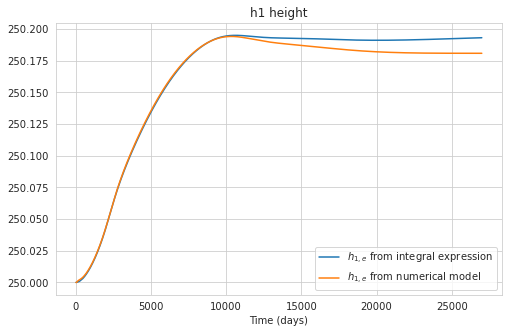

In [6]:
#Check our solution for eastern boundary height vs the true eastern boundary height


fig,ax=plt.subplots(figsize=(8,5))
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h1_east_est)
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h1_xr_bottom[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h1 height')
plt.legend(['$h_{1,e}$ from integral expression','$h_{1,e}$ from numerical model'])

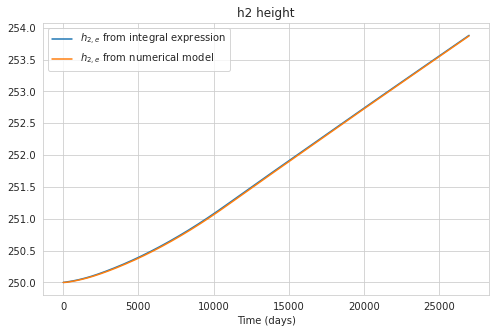

In [7]:
#Check our solution for eastern boundary height vs the true eastern boundary height


fig,ax=plt.subplots(figsize=(8,5))
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h2_east_est)
plt.plot(h1_xr_bottom[24:,127,:].time[0:4444],h2_xr_bottom[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h2 height')
plt.legend(['$h_{2,e}$ from integral expression','$h_{2,e}$ from numerical model'])

In [8]:
last=ny-ny//7

pred_h1_bottompert_grid=np.zeros([129-30,128-wbc]) #h1 height in the bottom perturbation experiment
pred_h2_bottompert_grid=np.zeros([129-30,128-wbc]) #h2 height in the bottom perturbation experiment
for j in range(30,129):
    for i in range(wbc,128):
        if (np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]>0:
            pred_h1_bottompert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
            pred_h2_bottompert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
        else: 
            pred_h1_bottompert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*H1+b4_1*H2
            pred_h2_bottompert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*H1+b4_2*H2


#convert these all to xarrays
h1_pred_bottompert=xr.DataArray(pred_h1_bottompert_grid, coords={'y': h1_xr_bottom.y[30:],'x':  h1_xr_bottom.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 
h2_pred_bottompert=xr.DataArray(pred_h2_bottompert_grid, coords={'y': h1_xr_bottom.y[30:],'x':  h1_xr_bottom.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 

Text(0.5, 0.98, 'Prediction throughout basin; numerical model vs analytics, $g_1^{\\prime}=2g_2^{\\prime}$ \n Bottom perturbation \n Prediction at 75 years')

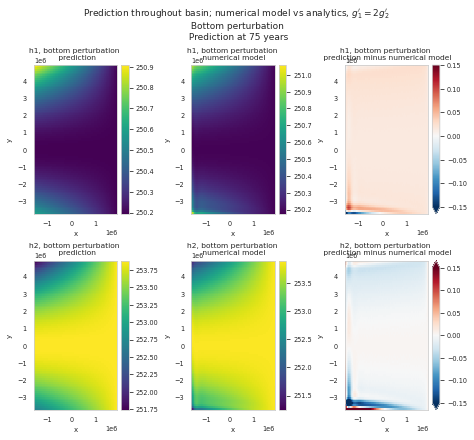

In [13]:
scaling=1/2 #use 1 if half width plot once put into latex. use 1/2 if full width once put into latex

rcParams.update({
    'font.size': 10 * scaling,
    'axes.titlesize': 15 * scaling,
    'axes.labelsize': 14 * scaling,
    'xtick.labelsize': 13 * scaling,
    'ytick.labelsize': 13 * scaling,
    'legend.fontsize': 11 * scaling,
})

fig,((ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(2,3,figsize=(6.47,6),constrained_layout=True)


(h1_pred_bottompert[:-ny//7,:]).plot(ax=ax7)
ax7.set_title('h1, bottom perturbation \n prediction')
(h1_xr_bottom[30:-ny//7,10:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax8)
ax8.set_title('h1, bottom perturbation \n numerical model')
(h1_pred_bottompert[:-ny//7]-h1_xr_bottom[30:-ny//7,10:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax9,vmax=0.15)
ax9.set_title('h1, bottom perturbation \n prediction minus numerical model')


(h2_pred_bottompert[:-ny//7,:]).plot(ax=ax10)
ax10.set_title('h2, bottom perturbation \n prediction')
(h2_xr_bottom[30:-ny//7,10:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax11)
ax11.set_title('h2, bottom perturbation \n numerical model')
(h2_pred_bottompert[:-ny//7]-h2_xr_bottom[30:-ny//7,10:,np.shape(h1_xr_bottom)[2]-1]).plot(ax=ax12,vmax=0.15)
ax12.set_title('h2, bottom perturbation \n prediction minus numerical model')

fig.suptitle('Prediction throughout basin; numerical model vs analytics, $g_1^{\prime}=2g_2^{\prime}$ \n Bottom perturbation \n Prediction at 75 years', fontsize=18*scaling)

## 2a. Make a prediction at every time instead of just the end time

In [14]:
pred_h1_bottompert_grid_time=np.zeros([129-30,128-wbc,np.shape(h1_east_est)[0]]) #h1 height in the bottom perturbation experiment
pred_h2_bottompert_grid_time=np.zeros([129-30,128-wbc,np.shape(h1_east_est)[0]]) #h2 height in the bottom perturbation experiment
for k in range(0,np.shape(h1_east_est)[0]):
    for j in range(30,129):
        for i in range(wbc,128):
            if (k-lag_l1_grid[j-30,i-wbc])>0:
                if (k-lag_l2_grid[j-30,i-wbc])>0:
                    pred_h1_bottompert_grid_time[j-30,i-wbc,k]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                    pred_h2_bottompert_grid_time[j-30,i-wbc,k]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                else: 
                    pred_h1_bottompert_grid_time[j-30,i-wbc,k]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*H1+b4_1*H1
                    pred_h2_bottompert_grid_time[j-30,i-wbc,k]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*H1+b4_2*H1
            else:
                pred_h1_bottompert_grid_time[j-30,i-wbc,k]=b1_1*H1+b2_1*H1+b3_1*H1+b4_1*H1
                pred_h2_bottompert_grid_time[j-30,i-wbc,k]=b1_2*H1+b2_2*H1+b3_2*H1+b4_2*H1

    print(k)

#convert these all to xarrays
h1_pred_bottompert_time=xr.DataArray(pred_h1_bottompert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time}, dims=["y", "x",'time']) #convert to an xarray 
h2_pred_bottompert_time=xr.DataArray(pred_h2_bottompert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_bottom.time}, dims=["y", "x","time"]) #convert to an xarray 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [15]:
with open('./intermediate_files_cleaned/pred_h1_bottompert_grid_time_250m_matchmitgcminput_g1equal2g2_revisions.npy', 'wb') as f:
    np.save(f,h1_pred_bottompert_time)
with open('./intermediate_files_cleaned/pred_h2_bottompert_grid_time_250m_matchmitgcminput_g1equal2g2_revisions.npy', 'wb') as f:
    np.save(f,h2_pred_bottompert_time)

# 3. Analytics to predict each layer thickness. Top layer perturbation

In [16]:
c1=np.zeros(np.size(h2_xr_top[:,10,10])-30)
for j in range(0,np.size(h2_xr_top[:,10,10])-30):
    c1[j]=(beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2
    
c2=np.zeros(np.size(h2_xr_top[:,10,10])-30)
for j in range(0,np.size(h2_xr_top[:,10,10])-30):
    c2[j]=(beta*g2)/(np.squeeze((f0 + beta*hy))[30+j])**2
    
    
B=np.sqrt((-H2*c2-H1*(c1+c2))**2-4*H1*H2*c1*c2)
lambda_1=(H2*c2+H1*(c1+c2))/2+B/2
lambda_2=(H2*c2+H1*(c1+c2))/2-B/2

    
wbc=12 

lag_l1_grid=np.zeros([129-30,128-wbc])
lag_l2_grid=np.zeros([129-30,128-wbc])

for j in range(30,129):
    for i in range(wbc,128):
        lag_l1_grid[j-30,i-wbc]=(((L_x-i*dx)/(lambda_1[j-30]))/(24*60*60*np.diff((h2_xr_top).time)[0])).astype('int')
        lag_l2_grid[j-30,i-wbc]=(((L_x-i*dx)/(lambda_2[j-30]))/(24*60*60*np.diff((h2_xr_top).time)[0])).astype('int')
lag_l1_grid=lag_l1_grid.astype('int')
lag_l2_grid=lag_l2_grid.astype('int')

In [17]:
# predict eastern boundary height!

#set up c1 and c2
last_grid_pt=ny-ny//7-7
c1=np.zeros(np.size(h1_xr_top[:,10,10])-ny//7-7-30)
for j in range(0,np.size(h1_xr_top[:,10,10])-ny//7-7-30):
    c1[j]=(beta*g1)/(np.squeeze((f0 + beta*hy))[30+j])**2
    
c2=np.zeros(np.size(h1_xr_top[:,10,10])-ny//7-7-30)
for j in range(0,np.size(h1_xr_top[:,10,10])-ny//7-7-30):
    c2[j]=(beta*g2)/(np.squeeze((f0 + beta*hy))[30+j])**2

# don't let c1/c2 diverge
c1_cap=copy.deepcopy(c1)
c1_cap[c1_cap>1/H1]=1/H1
c1_cap=c1_cap*(24*60*60)*np.diff((h1_xr_top).time)[0]

c2_cap=copy.deepcopy(c2)
c2_cap[c2_cap>1/H1]=(g2/g1)*1/H1
c2_cap=c2_cap*(24*60*60)*np.diff((h1_xr_top).time)[0]

#####set up coefficients
B=np.sqrt((-H2*c2-H1*(c1+c2))**2-4*H1*H2*c1*c2)
F=1/2-H1*(c1+c2)/(2*H2*c2)+B/(2*H2*c2)
G=-1/2+H1*(c1+c2)/(2*H2*c2)+B/(2*H2*c2)

#Coefficients for the h_1 lag equation
b1_1=G*H2*c2/B
b2_1=F*G*H2*c2/B
b3_1=F*H2*c2/B
b4_1=-F*G*H2*c2/B

#Coefficients for the h_2 lag equation
b1_2=H2*c2/B
b2_2=F*H2*c2/B
b3_2=-H2*c2/B
b4_2=G*H2*c2/B

b1_1=b1_1[0]
b2_1=b2_1[0]
b3_1=b3_1[0]
b4_1=b4_1[0]

b1_2=b1_2[0]
b2_2=b2_2[0]
b3_2=b3_2[0]
b4_2=b4_2[0]
#####
B=np.sqrt((-H2*c2_cap-H1*(c1_cap+c2_cap))**2-4*H1*H2*c1_cap*c2_cap)
lambda_1=(H2*c2_cap+H1*(c1_cap+c2_cap))/2+B/2
lambda_2=(H2*c2_cap+H1*(c1_cap+c2_cap))/2-B/2



lag_l1=(((128-wbc)/128)*L_x/(lambda_1)).astype('int')
lag_l2=(((128-wbc)/128)*L_x/(lambda_2)).astype('int')
lag_l1[lag_l1==0]=1
lag_l2[lag_l2==0]=1


h1_east_est=H1*np.ones(4444)
h2_east_est=H2*np.ones(4444)
for k in range(0,4444):
    est_h1_bd=H2*np.ones(np.size(c1))
    est_h2_bd=H2*np.ones(np.size(c1))
    #estimate western bdd of top layer
    for j in range(0,np.size(c1)):
        if k-lag_l1[j]>0:
            est_h1_bd[j]=b1_1*h1_east_est[k-lag_l1[j]]+b2_1*h2_east_est[k-lag_l1[j]]
            if k-lag_l2[j]>0:
                est_h1_bd[j]+=b3_1*h1_east_est[k-lag_l2[j]]+b4_1*h2_east_est[k-lag_l2[j]]
            if k-lag_l2[j]<=0:
                est_h1_bd[j]+=b3_1*H1+b4_1*H2
    #estimate western bdd of top layer        
    for j in range(0,np.size(c1)):
            if k-lag_l1[j]>0:
                est_h2_bd[j]=b1_2*h1_east_est[k-lag_l1[j]]+b2_2*h2_east_est[k-lag_l1[j]]
                if k-lag_l2[j]>0:
                    est_h2_bd[j]+=b3_2*h1_east_est[k-lag_l2[j]]+b4_2*h2_east_est[k-lag_l2[j]]
                if k-lag_l2[j]<=0:
                    est_h2_bd[j]+=b3_2*H1+b4_2*H2
                
                
    h1_diff_squared=(h1_east_est[k-1]**2-h1_xr_top[30,0,k]**2)
    h2_diff_squared=(h2_east_est[k-1]**2-h2_xr_top[30,0,k]**2)
    doublef_south=2*(np.squeeze((f0 + beta*hy))[30])

    T_s1=(h1_diff_squared*(g2/doublef_south+g1/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_top).time)[0]
    T_s2=(h1_diff_squared*(g2/doublef_south)+h2_diff_squared*(g2/doublef_south))*(24*60*60)*np.diff((h1_xr_top).time)[0]


    h1_diff_squared_n=(h1_east_est[k-1]**2-h1_xr_top[last_grid_pt,0,k]**2)
    h2_diff_squared_n=(h2_east_est[k-1]**2-h2_xr_top[last_grid_pt,0,k]**2)
    doublef_north=2*(np.squeeze((f0 + beta*hy))[last_grid_pt])
    
    T_n1=(h1_diff_squared_n*(g2/doublef_north+g1/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_top).time)[0]
    T_n2=(h1_diff_squared_n*(g2/doublef_north)+h2_diff_squared_n*(g2/doublef_north))*(24*60*60)*np.diff((h1_xr_top).time)[0]

    
    h1_east_est[k]=((dy*c1_cap*est_h1_bd).sum()+T_s1/H1-T_s2/H2-T_n1/H1+T_n2/H2)/(c1_cap*dy).sum()
    h2_east_est[k]=((dy*c2_cap*(est_h1_bd+est_h2_bd)).sum()+T_s2/H2-T_n2/H2-(h1_east_est[k]*c2_cap*dy).sum())/(c2_cap*dy).sum()

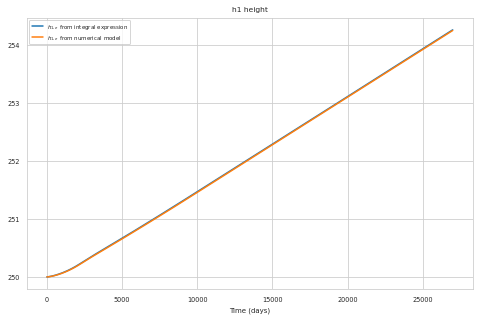

In [18]:
#Check our solution for eastern boundary height vs the true eastern boundary height


fig,ax=plt.subplots(figsize=(8,5))
plt.plot(h1_xr_top[24:,127,:].time[0:4444],h1_east_est)
plt.plot(h1_xr_top[24:,127,:].time[0:4444],h1_xr_top[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h1 height')
plt.legend(['$h_{1,e}$ from integral expression','$h_{1,e}$ from numerical model'])

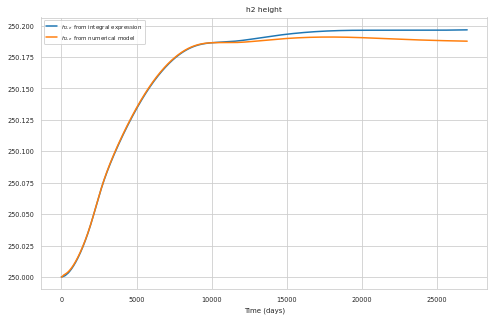

In [19]:
#Check our solution for eastern boundary height vs the true eastern boundary height


fig,ax=plt.subplots(figsize=(8,5))
plt.plot(h1_xr_top[24:,127,:].time[0:4444],h2_east_est)
plt.plot(h1_xr_top[24:,127,:].time[0:4444],h2_xr_top[30:-ny//7,127,:].mean('y')[0:4444])
plt.xlabel('Time (days)')
plt.title('h2 height')
plt.legend(['$h_{2,e}$ from integral expression','$h_{2,e}$ from numerical model'])

In [20]:
last=ny-ny//7

pred_h1_toppert_grid=np.zeros([129-30,128-wbc]) #h1 height in the top perturbation experiment
pred_h2_toppert_grid=np.zeros([129-30,128-wbc]) #h2 height in the top perturbation experiment
for j in range(30,129):
    for i in range(wbc,128):
        if (np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]>0:
            pred_h1_toppert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
            pred_h2_toppert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l2_grid[j-30,i-wbc]]
        else: 
            pred_h1_toppert_grid[j-30,i-wbc]=b1_1*h1_east_est[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_1*H1+b4_1*H2
            pred_h2_toppert_grid[j-30,i-wbc]=b1_2*(h1_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(np.shape(h1_east_est)[0]-1)-lag_l1_grid[j-30,i-wbc]]+b3_2*H1+b4_2*H2


#convert these all to xarrays
h1_pred_toppert=xr.DataArray(pred_h1_toppert_grid, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 
h2_pred_toppert=xr.DataArray(pred_h2_toppert_grid, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:]}, dims=["y", "x"]) #convert to an xarray 

Text(0.5, 0.98, 'Prediction throughout basin; numerical model vs analytics, $g_1^{\\prime}=2g_2^{\\prime}$ \n Top perturbation \n Prediction at 75 years')

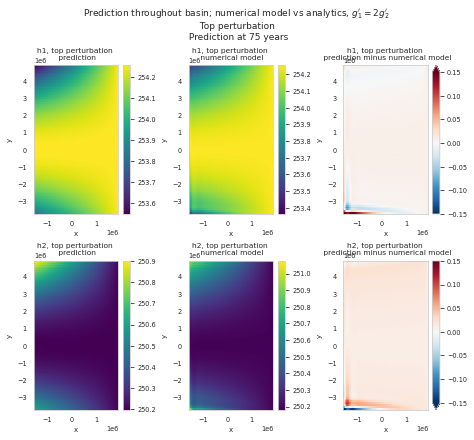

In [24]:
scaling=1/2 #use 1 if half width plot once put into latex. use 1/2 if full width once put into latex

rcParams.update({
    'font.size': 10 * scaling,
    'axes.titlesize': 15 * scaling,
    'axes.labelsize': 14 * scaling,
    'xtick.labelsize': 13 * scaling,
    'ytick.labelsize': 13 * scaling,
    'legend.fontsize': 11 * scaling,
})

fig,((ax7,ax8,ax9),(ax10,ax11,ax12))=plt.subplots(2,3,figsize=(6.47,6),constrained_layout=True)


(h1_pred_toppert[:-ny//7,:]).plot(ax=ax7)
ax7.set_title('h1, top perturbation \n prediction')
(h1_xr_top[30:-ny//7,10:,np.shape(h1_xr_top)[2]-1]).plot(ax=ax8)
ax8.set_title('h1, top perturbation \n numerical model')
(h1_pred_toppert[:-ny//7]-h1_xr_top[30:-ny//7,10:,np.shape(h1_xr_top)[2]-1]).plot(ax=ax9,vmax=0.15)
ax9.set_title('h1, top perturbation \n prediction minus numerical model')


(h2_pred_toppert[:-ny//7,:]).plot(ax=ax10)
ax10.set_title('h2, top perturbation \n prediction')
(h2_xr_top[30:-ny//7,10:,np.shape(h1_xr_top)[2]-1]).plot(ax=ax11)
ax11.set_title('h2, top perturbation \n numerical model')
(h2_pred_toppert[:-ny//7]-h2_xr_top[30:-ny//7,10:,np.shape(h1_xr_top)[2]-1]).plot(ax=ax12,vmax=0.15)
ax12.set_title('h2, top perturbation \n prediction minus numerical model')

fig.suptitle('Prediction throughout basin; numerical model vs analytics, $g_1^{\prime}=2g_2^{\prime}$ \n Top perturbation \n Prediction at 75 years', fontsize=18*scaling)

## 3a. Make a prediction at every time instead of just the end time

In [22]:
pred_h1_toppert_grid_time=np.zeros([129-30,128-wbc,np.shape(h1_east_est)[0]]) #h1 height in the top perturbation experiment
pred_h2_toppert_grid_time=np.zeros([129-30,128-wbc,np.shape(h1_east_est)[0]]) #h2 height in the top perturbation experiment
for k in range(0,np.shape(h1_east_est)[0]):
    for j in range(30,129):
        for i in range(wbc,128):
            if (k-lag_l1_grid[j-30,i-wbc])>0:
                if (k-lag_l2_grid[j-30,i-wbc])>0:
                    pred_h1_toppert_grid_time[j-30,i-wbc,k]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_1*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                    pred_h2_toppert_grid_time[j-30,i-wbc,k]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*(h1_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]+b4_2*(h2_east_est)[(k)-lag_l2_grid[j-30,i-wbc]]
                else: 
                    pred_h1_toppert_grid_time[j-30,i-wbc,k]=b1_1*h1_east_est[(k)-lag_l1_grid[j-30,i-wbc]]+b2_1*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_1*H1+b4_1*H1
                    pred_h2_toppert_grid_time[j-30,i-wbc,k]=b1_2*(h1_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b2_2*(h2_east_est)[(k)-lag_l1_grid[j-30,i-wbc]]+b3_2*H1+b4_2*H1
            else:
                pred_h1_toppert_grid_time[j-30,i-wbc,k]=b1_1*H1+b2_1*H1+b3_1*H1+b4_1*H1
                pred_h2_toppert_grid_time[j-30,i-wbc,k]=b1_2*H1+b2_2*H1+b3_2*H1+b4_2*H1

    print(k)

#convert these all to xarrays
h1_pred_toppert_time=xr.DataArray(pred_h1_toppert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_top.time}, dims=["y", "x",'time']) #convert to an xarray 
h2_pred_toppert_time=xr.DataArray(pred_h2_toppert_grid_time, coords={'y': h1_xr_top.y[30:],'x':  h1_xr_top.x[wbc:], 'time': h1_xr_top.time}, dims=["y", "x","time"]) #convert to an xarray 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [23]:
with open('./intermediate_files_cleaned/pred_h1_toppert_grid_time_250m_matchmitgcminput_g1equal2g2_revisions.npy', 'wb') as f:
    np.save(f,h1_pred_toppert_time)
with open('./intermediate_files_cleaned/pred_h2_toppert_grid_time_250m_matchmitgcminput_g1equal2g2_revisions.npy', 'wb') as f:
    np.save(f,h2_pred_toppert_time)